In [1]:
'''
import numpy as np
import cv2 as cv
img = cv.imread('Hyun_Soo_target1.jpg')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)
img = cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite('sift_keypoints.jpg',img)
'''

"\nimport numpy as np\nimport cv2 as cv\nimg = cv.imread('Hyun_Soo_target1.jpg')\ngray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)\nsift = cv.xfeatures2d.SIFT_create()\nkp, des = sift.detectAndCompute(gray,None)\nimg = cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)\ncv.imwrite('sift_keypoints.jpg',img)\n"

In [2]:
def visualize_find_match(img1, img2, x1, x2, img_h=500):
    assert x1.shape == x2.shape, 'x1 and x2 should have same shape!'
    scale_factor1 = img_h/img1.shape[0]
    scale_factor2 = img_h/img2.shape[0]
    img1_resized = cv2.resize(img1, None, fx=scale_factor1, fy=scale_factor1)
    img2_resized = cv2.resize(img2, None, fx=scale_factor2, fy=scale_factor2)
    x1 = x1 * scale_factor1
    x2 = x2 * scale_factor2
    x2[:, 0] += img1_resized.shape[1]
    img = np.hstack((img1_resized, img2_resized))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    for i in range(x1.shape[0]):
        plt.plot([x1[i, 0], x2[i, 0]], [x1[i, 1], x2[i, 1]], 'b')
        plt.plot([x1[i, 0], x2[i, 0]], [x1[i, 1], x2[i, 1]], 'bo')
    plt.axis('off')
    plt.show()

def visualize_align_image(template, target, A, A_refined, errors=None):
    img_warped_init = warp_image(target, A, template.shape)
    img_warped_optim = warp_image(target, A_refined, template.shape)
    err_img_init = np.abs(img_warped_init - template)
    err_img_optim = np.abs(img_warped_optim - template)
    img_warped_init = np.uint8(img_warped_init)
    img_warped_optim = np.uint8(img_warped_optim)
    overlay_init = cv2.addWeighted(template, 0.5, img_warped_init, 0.5, 0)
    overlay_optim = cv2.addWeighted(template, 0.5, img_warped_optim, 0.5, 0)
    plt.subplot(241)
    plt.imshow(template, cmap='gray')
    plt.title('Template')
    plt.axis('off')
    plt.subplot(242)
    plt.imshow(img_warped_init, cmap='gray')
    plt.title('Initial warp')
    plt.axis('off')
    plt.subplot(243)
    plt.imshow(overlay_init, cmap='gray')
    plt.title('Overlay')
    plt.axis('off')
    plt.subplot(244)
    plt.imshow(err_img_init, cmap='jet')
    plt.title('Error map')
    plt.axis('off')
    plt.subplot(245)
    plt.imshow(template, cmap='gray')
    plt.title('Template')
    plt.axis('off')
    plt.subplot(246)
    plt.imshow(img_warped_optim, cmap='gray')
    plt.title('Opt. warp')
    plt.axis('off')
    plt.subplot(247)
    plt.imshow(overlay_optim, cmap='gray')
    plt.title('Overlay')
    plt.axis('off')
    plt.subplot(248)
    plt.imshow(err_img_optim, cmap='jet')
    plt.title('Error map')
    plt.axis('off')
    plt.show()

    if errors is not None:
        plt.plot(errors * 255)
        plt.xlabel('Iteration')
        plt.ylabel('Error')
        plt.show()


def visualize_track_multi_frames(template, img_list, A_list):
    bbox_list = []
    for A in A_list:
        boundary_t = np.hstack((np.array([[0, 0], [template.shape[1], 0], [template.shape[1], template.shape[0]],
                                        [0, template.shape[0]], [0, 0]]), np.ones((5, 1)))) @ A[:2, :].T
        bbox_list.append(boundary_t)

    plt.subplot(221)
    plt.imshow(img_list[0], cmap='gray')
    plt.plot(bbox_list[0][:, 0], bbox_list[0][:, 1], 'r')
    plt.title('Frame 1')
    plt.axis('off')
    plt.subplot(222)
    plt.imshow(img_list[1], cmap='gray')
    plt.plot(bbox_list[1][:, 0], bbox_list[1][:, 1], 'r')
    plt.title('Frame 2')
    plt.axis('off')
    plt.subplot(223)
    plt.imshow(img_list[2], cmap='gray')
    plt.plot(bbox_list[2][:, 0], bbox_list[2][:, 1], 'r')
    plt.title('Frame 3')
    plt.axis('off')
    plt.subplot(224)
    plt.imshow(img_list[3], cmap='gray')
    plt.plot(bbox_list[3][:, 0], bbox_list[3][:, 1], 'r')
    plt.title('Frame 4')
    plt.axis('off')
    plt.show()

In [3]:
## Imports
import cv2
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy import interpolate

In [4]:
def find_match(img1, img2):

    ## SIFT 
    sift = cv2.xfeatures2d.SIFT_create(edgeThreshold=5,contrastThreshold=0.025)
    kp1,des1 = sift.detectAndCompute(img1,None)
    kp2,des2 = sift.detectAndCompute(img2,None)

    ## Neighbors
    nbrs = NearestNeighbors(n_neighbors=2).fit(des1)
    dists,idxs = nbrs.kneighbors(des2)
    nbrs2 = NearestNeighbors(n_neighbors=2).fit(des2)
    dists2,idxs2 = nbrs2.kneighbors(des1)

    ## Ratio
    x1,x2 = [],[]
    for i,dist in enumerate(dists):
        if dist[0]/dist[1] < 0.7:
            x1.append(kp1[idxs[i][0]].pt)
            x2.append(kp2[i].pt)
    x1_,x2_ = [],[]
    for i,dist in enumerate(dists2):
        if dist[0]/dist[1] < 0.7:
            x1_.append(kp1[i].pt)
            x2_.append(kp2[idxs2[i][0]].pt)
    dists = []
    final_x1,final_x2 = [],[]
    for i,ele in enumerate(x1):
        for j,ele2 in enumerate(x1_):
            if np.linalg.norm(np.array(ele)-np.array(ele2)) < 200:
                if np.linalg.norm(np.array(x2[i])-np.array(x2_[j])) < 200:
                    final_x2.append(x2[i])
                    final_x1.append(ele)
                    
    return np.array(final_x1),np.array(final_x2)

In [5]:
img1 = cv2.imread('Hyun_Soo_template.jpg')
img2 = cv2.imread('Hyun_Soo_target1.jpg')
x1,x2 = find_match(img1,img2)
'''
img1 = cv2.drawKeypoints(img1,x1[45:50],img1,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2 = cv2.drawKeypoints(img2,x2[45:50],img2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('x1.jpg',img1)
cv2.imwrite('x2.jpg',img2)

'''

"\nimg1 = cv2.drawKeypoints(img1,x1[45:50],img1,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)\nimg2 = cv2.drawKeypoints(img2,x2[45:50],img2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)\ncv2.imwrite('x1.jpg',img1)\ncv2.imwrite('x2.jpg',img2)\n\n"

In [6]:
ransac_thr = 1
ransac_iter = 2000
x1,x2 = find_match(img1,img2)

In [7]:
def align_image_using_feature(x1, x2, ransac_thr, ransac_iter):
    best = []
    mats = []
    max_ = 0
    mat = 0
    for iter in range(ransac_iter):
        coords = np.random.randint(len(x2),size=3)
        A = []
        b = []
        ## Stack 3 random correlations
        for i,c in enumerate(coords):
            x,y = x1[c][0],x1[c][1]
            xp,yp = x2[c][0],x2[c][1]
            A.append([x,y,1,0,0,0])
            A.append([0,0,0,x,y,1])
            b.append(xp)
            b.append(yp)  

        A,b = np.array(A), np.array(b).T 
        try:
            t = np.linalg.solve(A,b)
        except np.linalg.LinAlgError:
            continue

        t = t.reshape((6,1))
        t = np.vstack((t,np.array([[0],[0],[1]]))).reshape((3,3))
        ## calc inliers
        x_1,x_2 = [],[]
        for i,c in enumerate(x1):
            old = np.array([x1[i][0],x1[i][1],1])
            new = np.array([x2[i][0],x2[i][1],1])
            est = (t @ old)
            err = np.linalg.norm(est-new)
            if err < 10:
                x_1.append([x1[i][0],x1[i][1],1])
                x_2.append([x2[i][0],x2[i][1],1])
        x_1 = np.array(x_1)
        x_2 = np.array(x_2)
        mx = len(x_2)
        if mx > max_:
            max_ = mx
            mat = t
            
    return(mat)

In [8]:
def warp_image(img, A, output_size):
    output = np.zeros(output_size)
    
    xvals = np.arange(output_size[0])
    yvals = np.arange(output_size[1])
    ones = np.ones(output_size[0]*output_size[1])
    ones = ones.reshape(output_size[0]*output_size[1],1)
    
    XX,YY = np.meshgrid(yvals,xvals)
    coords = np.dstack([XX, YY]).reshape(-1, 2)
    coords = np.hstack([coords,ones])
    out = coords @ A.T
    out = np.delete(out,-1,axis=1)
    print(out.shape)
    
    out = out.reshape((output_size[0],output_size[1],2))
    for i in range(output_size[0]):
        for j in range(output_size[1]):
            try:
                output[i][j] = img[int(out[i][j][1])][int(out[i][j][0])]
            except IndexError:
                continue
    
    
    ## Interpolation not needed - no "holes" in image
    
    
    return(output)


(452, 292)
(812, 1441)


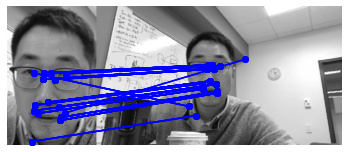

In [9]:
template = cv2.imread('./Hyun_Soo_template.jpg', 0)  # read as grey scale image
target_list = []
for i in range(4):
    target = cv2.imread('./Hyun_Soo_target{}.jpg'.format(i+1), 0)  # read as grey scale image
    target_list.append(target)
print(template.shape)
print(target_list[0].shape)
x1, x2 = find_match(template, target_list[0])
visualize_find_match(template, target_list[0], x1, x2)

In [10]:
A = align_image_using_feature(x1, x2, ransac_thr, ransac_iter)
print(A)

[[ 1.03085223e+00 -3.99167223e-02  5.35664005e+02]
 [-6.67204134e-05  1.06972992e+00  1.10480116e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


(131984, 2)


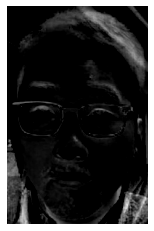

In [11]:

img_warped = warp_image(target_list[0], A, template.shape)

img_warped -= template
img_warped *= 1.25

plt.imshow(img_warped, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()



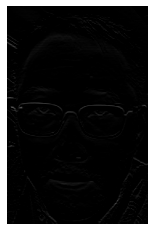

In [20]:
template = cv2.imread('./Hyun_Soo_template.jpg', 0) 
template = np.gradient(template,axis=0)*1.5
plt.imshow(template, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

In [31]:
template = cv2.imread('./Hyun_Soo_template.jpg', 0) 

## Gradients
p = A
x_grad = np.gradient(template,axis=0)
y_grad = np.gradient(template,axis=1)

## Jacobians
jacobs = []
for i,line in enumerate(template):
    for j,px in enumerate(line):
        jac = [[i,0,j,0,1,0],[0,i,0,j,0,1]]
        jacobs.append(jac)
jacobs = np.array(jacobs)
print(jacobs.shape)

## Steepest descent
images = [np.zeros_like(template) for i in range(6)]
for i,line in enumerate(template):
    for j,px in enumerate(line): 
        for k in range(6):
            a = np.array([jacobs[i*j][0][k],jacobs[i*j][1][k]])
            b = np.array([x_grad[i][j],y_grad[i][j]])
            images[k][i][j] = np.dot(a,b)


(131984, 2, 6)
6


In [73]:
steep_desc = []
for i in range(len(images)):
    steep_desc.append(images[i].flatten())
steep_desc = np.array(steep_desc)

hessian = steep_desc @ steep_desc.T
print(hessian.shape)

(6, 6)


In [74]:
while np.linalg.norm(p) < 2000:
    warped = warp_image(target, p, template.shape)
    err = warped - template
    F = steep_desc.T * err
    dp = np.linalg.inv(hessian) @ F
    print(dp.shape)

(131984, 2)


ValueError: operands could not be broadcast together with shapes (131984,6) (452,292) 